# Svenskt Kvinnobiografiskt lexikon part 3
version part 3 - 1.10


* this [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) 
  * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL
  * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
  * [part 4](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%204.ipynb) get archives
* [video](https://www.youtube.com/watch?v=6jxH8MBIhvg) in Swedish about how SKBL deliver and work with Wikidata
  * Example how project Women in Red at en:Wikipedia automatic [creates list](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) that shows what in SKBL has an english article about a women but not have an english article in en:Wikipedia
    * see [version history](https://en.wikipedia.org/w/index.php?title=Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW&action=history) of list created
    * see en:Wikipedia articles [with a link to SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 680 articles

# Get metadata from SKBL and use it on the articles using Wikidata
Below we check Wikidata and SKBL to see if SKBL is updated

* This is also a test getting some more data as the author data from SKBL  

If we get this data with license [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) "No rights reserved" we can store it in [Wikidata](https://www.wikidata.org/wiki/Wikidata:Licensing) and use it on all > 1500 articles in [sv:Wikipedia](https://sv.wikipedia.org/wiki/Kategori:SKBL) and [en:Wikipedia](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) using the [template SKBL](https://en.wikipedia.org/wiki/Template:SKBL) see also [Template Talk SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template) 

and display who the author is of the article in SKBL e.g. 
* Nauman, Sari [Ulrika Eleonora d.y., drottning](https://skbl.se/en/article/UlrikaEleonoradydrottning) at [Svenskt kvinnobiografiskt lexikon](https://en.wikipedia.org/wiki/Svenskt_kvinnobiografiskt_lexikon)

**See also**
* video [Introduction to WIkidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

# Wikidata

In [1]:
from datetime import datetime
now = datetime.now()
print("Last run: ", now)

Last run:  2020-09-10 17:05:54.169012


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 


In [3]:
WDSKBLtot.sort_index(inplace=True)  

In [4]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 3 columns):
wid       1487 non-null object
skblid    1487 non-null object
Source    1487 non-null object
dtypes: object(3)
memory usage: 35.0+ KB


In [5]:
import csv  
import urllib3, json
http = urllib3.PoolManager() 

jsonURL = "https://skbl.se/sv/artikel/"
listNewItems =[]
for index,row in WDSKBLtot.iterrows():
    url = jsonURL + row["skblid"] + ".json"
    r = http.request('GET', url) 
    data = json.loads(r.data.decode('utf-8'))  
    new_item = dict()
    new_item['skblid'] = row["skblid"]
    new_item['wid'] = row["wid"]
    try:
        publishedDate = data['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = data['article_author'][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = data['article_author'][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = data['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        subtitle_eng = data['subtitle_eng']
    except:
        subtitle_eng =""
    new_item['subtitle_eng'] = subtitle_eng
    try:
        name_lastname = data['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = data['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")


1487  antal poster


In [6]:
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SKBLAuthor_newfile.csv", "w", newline='') as SKBLfile:
        dict_writer = csv.DictWriter(SKBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSKBLAuthorcsv = pd.read_csv("SKBLAuthor_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 
            


In [7]:
dfSKBLAuthorcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 9 columns):
skblid                      1487 non-null object
wid                         1487 non-null object
publishedDate               1487 non-null object
article_author_firstname    1485 non-null object
article_author_lastname     1485 non-null object
subtitle_sv                 1487 non-null object
subtitle_eng                1484 non-null object
name_lastname               1455 non-null object
name_firstname              1487 non-null object
dtypes: object(9)
memory usage: 104.7+ KB


## Store Authorname in WIkidata 

1. Step nr one is that we just add the author as a text string e.g.
  1. Example article UlrikaEleonoradydrottning has in metadata json see line 1 below  

    1. article_author_firstname: "Sari"
    1. article_author_lastname: "Nauman" 
    
I guess then we create a authorname string **Nauman, Sari**

Many of the authors has an Wikipedia article on Swedish Wikipedia --> then we could add the author as a Wikilink e.g.
Lisbeth Larsson [Q4961115](https://www.wikidata.org/wiki/Q4961115) is same as SKBL [articleauthor/Larsson, Lisbeth](https://skbl.se/en/articleauthor/Larsson%2C%20Lisbeth)  

See also [en:Wikipedia:Template:Talk:SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template)

In [8]:
dfSKBLAuthorcsv["publishedDate"] = dfSKBLAuthorcsv["publishedDate"].astype("datetime64")
dfSKBLAuthorcsv["Source"] = "SKBL"

In [9]:
%matplotlib inline    
import matplotlib.pyplot as plt   


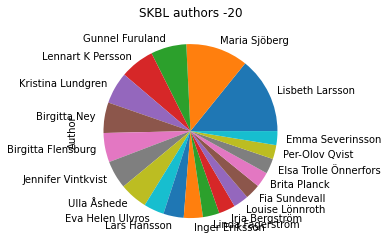

In [10]:
plotPublishedAuthor =   dfSKBLAuthorcsv  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors -20")
plt.show()

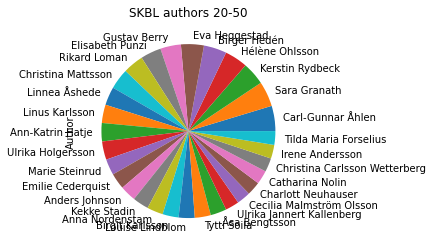

In [11]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors 20-50")
plt.show()

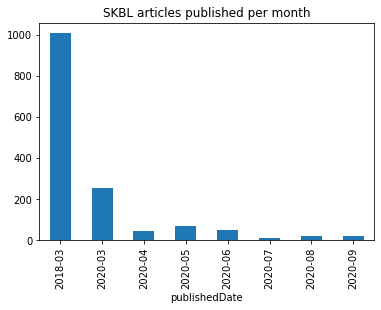

In [12]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(dfSKBLAuthorcsv.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month")
plt.show()

In [13]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      23
Freq: M, Name: publishedDate, dtype: int64

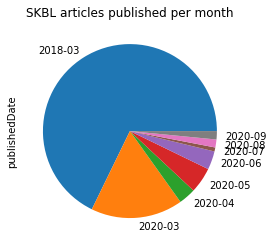

In [14]:
plotPublishedperMonth.plot( kind = 'pie') 
plt.title("SKBL articles published per month")
plt.show()

In [15]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [16]:
from IPython.display import display, HTML  
plotPublishedAuthor['Link'] = plotPublishedAuthor['skblid'].apply(lambda x: "https://skbl.se/sv/artikel/{0}".format(x))  
plotPublishedAuthor.style.set_properties(subset=['publishedDate'], **{'width': '200px'}) 
plotPublishedAuthor = plotPublishedAuthor.sort_values(by=['publishedDate'], ascending=[False])
plotPublishedAuthor = plotPublishedAuthor.reset_index(drop=True)  

# de sista 10 publiserade biografier 
plotPublishedAuthor[:10]

,skblid,wid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname,Source,Author,Link
0,HilmaMariaHofstedt,Q99186528,2020-09-10,Michaela,Malmberg,"Politiker, facklig agitator, sexualupplysare","Politician, trade union agitator, sexual educator",Hofstedt,/Hilma/ Maria,SKBL,Michaela Malmberg,https://skbl.se/sv/artikel/HilmaMariaHofstedt
1,AidaMargaretaTornell,Q16467608,2020-09-10,Ulrika,Jannert Kallenberg,"Översättare, statstjänsteman","Translator, civil servant",Törnell,/Aida/ Margareta,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/AidaMargaretaTornell
2,MajGunnelSamzelius,Q21065195,2020-09-10,Annmarie,Kastrup,"Skådespelare, dramatiker, teaterpedagog","Actor, playwright, theatre teacher",Samzelius,/Maj/ Gunnel,SKBL,Annmarie Kastrup,https://skbl.se/sv/artikel/MajGunnelSamzelius
3,HannaEstridTenggren,Q53614296,2020-09-09,Ulrika,Jannert Kallenberg,"Översättare, korrekturläsare, slöjdlärare","Translator, proofreader, crafts teacher",Tenggren,Hanna /Estrid/,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/HannaEstridTenggren
4,KerstinMargaretaTovi,Q53615791,2020-09-09,Ulrika,Jannert Kallenberg,Översättare,Translator,Tovi,/Kerstin/ Margareta,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/KerstinMargaretaTovi
5,AnnSofiSchotteLindsten,Q99035949,2020-09-09,Margit,Werner,"Konsthistoriker, museitjänsteman, lärare","Art historian, museum official, teacher",Schotte-Lindsten,/Ann-Sofi/,SKBL,Margit Werner,https://skbl.se/sv/artikel/AnnSofiSchotteLindsten
6,AlbertinaFredrikaIkaPeyron,Q1195141,2020-09-07,Magdalena,Fronczak,"Kompositör, pianist, filantrop","Composer, pianist, philanthropist",Peyron,Albertina Fredrika (/Ika/),SKBL,Magdalena Fronczak,https://skbl.se/sv/artikel/AlbertinaFredrikaIk...
7,IdaElisabethMatton,Q4966391,2020-09-07,Barbro,Norbelie,"Konstnär, skulptör","Artist, sculptor",Matton,/Ida/ Elisabeth,SKBL,Barbro Norbelie,https://skbl.se/sv/artikel/IdaElisabethMatton
8,MathildaNaumann,Q33133977,2020-09-07,Anna Maria,Ursing,"Författare, filantrop","Author, philanthropist",Naumann,Sofia /Mathilda/,SKBL,Anna Maria Ursing,https://skbl.se/sv/artikel/MathildaNaumann
9,MarianneLindsten,Q4962945,2020-09-04,Jan,Thomasson,"Provinsialläkare, pionjär, kvinnosakskvinna","Pioneering district medical officer, proponent...",Lindstén,/Marianne/ Charlotta,SKBL,Jan Thomasson,https://skbl.se/sv/artikel/MarianneLindsten


## Compare SBL
SBL started in 1918 and is published by the [National Archives](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually and doing webscrabing populated [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883) Oct 30 2019, 11:03 AM - no official answer so far and The Swedish National Archives has no helpdesk system were you get an unique helpdesk number ([some action was promised aug 2018 by Rolf Källman](https://twitter.com/salgo60/status/1030269242296414208?s=20) nothing heard)


In [17]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid  ?genderLabel  WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
?item wdt:P3217 ?sblid
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7527 entries, 0 to 7526
Data columns (total 4 columns):
wid            7527 non-null object
sblid          7527 non-null object
genderLabel    7527 non-null object
Source         7527 non-null object
dtypes: object(4)
memory usage: 235.3+ KB


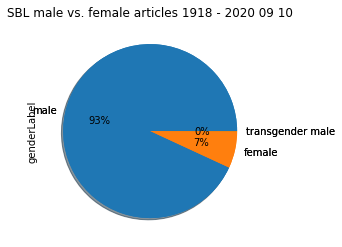

In [18]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.title("Riksarkivet SBL male/female")
plot = plotSBLgender.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL male vs. female articles 1918 - " + now.strftime('%Y %m %d'))

plt.show()

In [19]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7527 entries, 0 to 7526
Data columns (total 4 columns):
wid            7527 non-null object
sblid          7527 non-null object
genderLabel    7527 non-null object
Source         7527 non-null object
dtypes: object(4)
memory usage: 235.3+ KB


In [20]:
WDSBLtot.duplicated(subset=['wid']).sum()

1

In [21]:
plotSBLgender

male                7008
female               518
transgender male       1
Name: genderLabel, dtype: int64

In [22]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
plotSBLfemale.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 7 to 7508
Data columns (total 4 columns):
wid            518 non-null object
sblid          518 non-null object
genderLabel    518 non-null object
Source         518 non-null object
dtypes: object(4)
memory usage: 20.2+ KB


In [23]:
#Merge dfSKBLAuthorcsv and plotSBLfemale 


In [24]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-10 17:14:22.296817


In [25]:
dfmerge = pd.merge(plotSBLfemale, plotPublishedAuthor,how='outer', on='wid',indicator=True)

In [26]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 16 columns):
wid                         1683 non-null object
sblid                       518 non-null object
genderLabel                 518 non-null object
Source_x                    518 non-null object
skblid                      1487 non-null object
publishedDate               1487 non-null datetime64[ns]
article_author_firstname    1485 non-null object
article_author_lastname     1485 non-null object
subtitle_sv                 1487 non-null object
subtitle_eng                1484 non-null object
name_lastname               1455 non-null object
name_firstname              1487 non-null object
Source_y                    1487 non-null object
Author                      1485 non-null object
Link                        1487 non-null object
_merge                      1683 non-null category
dtypes: category(1), datetime64[ns](1), object(14)
memory usage: 212.1+ KB


In [27]:
dfmerge["_merge"].value_counts()

right_only    1165
both           322
left_only      196
Name: _merge, dtype: int64

In [28]:
# both is number in bioth SBL and SKBL   
# right_only is SBL
# left_only is SKBL

In [29]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','SBL_only').str.replace('right_only','SKBL_only')
dfmerge[0:10]

,wid,sblid,genderLabel,Source_x,skblid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname,Source_y,Author,Link,_merge
0,Q1794132,10025,female,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
1,Q3431866,10043,female,SBL,MarianneLofgren,2018-03-08,Jennifer,Vintkvist,Skådespelare,Actor,Löfgren,Jeannette Wedday /Marianne/ Ida Carolina,SKBL,Jennifer Vintkvist,https://skbl.se/sv/artikel/MarianneLofgren,both
2,Q4964675,10125,female,SBL,HarrietLowenhjelm,2018-03-08,Boel,Hackman,"Författare, konstnär","Author, artist",Löwenhjelm,/Harriet/ Augusta Dorothea,SKBL,Boel Hackman,https://skbl.se/sv/artikel/HarrietLowenhjelm,both
3,Q4942488,10132,female,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
4,Q4965144,10184,female,SBL,MathildaMalling,2018-03-08,Birgitta,Ney,Författare,Author,Malling,Ingrid /Mathilda/,SKBL,Birgitta Ney,https://skbl.se/sv/artikel/MathildaMalling,both
5,Q16595614,10248,female,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
6,Q4968661,10331,female,SBL,EbbaMansdotterLilliehook0,2020-03-02,Jan,Samuelson,"Grevinna, godsägare","Countess, property owner",Månsdotter (Lilliehöök),/Ebba/,SKBL,Jan Samuelson,https://skbl.se/sv/artikel/EbbaMansdotterLilli...,both
7,Q16595619,10332,female,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
8,Q4962236,10390,female,SBL,FredrikaCatharinaLimnell,2020-03-02,Birgitta,Jordansson,"Kvinnosakskvinna, salongsvärdinna, mecenat","Proponent of women's issues, hostess of cultur...",Limnell,/Fredrika/ Catharina,SKBL,Birgitta Jordansson,https://skbl.se/sv/artikel/FredrikaCatharinaLi...,both
9,Q42399094,10396,female,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only


In [30]:
mergeCheck = dfmerge[['wid', 'sblid','skblid','publishedDate','_merge']] 
mergeCheck.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 5 columns):
wid              1683 non-null object
sblid            518 non-null object
skblid           1487 non-null object
publishedDate    1487 non-null datetime64[ns]
_merge           1683 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 78.9+ KB


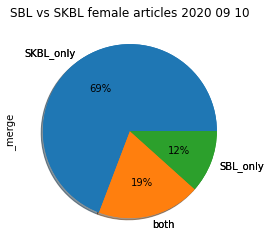

In [31]:
mergeCheckNumber = mergeCheck["_merge"].value_counts()
mergeCheckNumber.plot( kind = 'pie')  
plot = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL vs SKBL female articles " + now.strftime('%Y %m %d'))
plt.show()


In [32]:
mergeCheckNumber

SKBL_only    1165
both          322
SBL_only      196
Name: _merge, dtype: int64

In [33]:
#Profiles missing in SKBL that SBL has written = left_only 
WDSBLonly = mergeCheck[mergeCheck["_merge"] == "SBL_only"].copy() 

In [34]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 514
Data columns (total 5 columns):
wid              196 non-null object
sblid            196 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           196 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 9.2+ KB


In [35]:
WDSBLonly["sbl"] = "https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=" + WDSBLonly["sblid"] 
pd.set_option('column_space', 20)
pd.set_option('max_colwidth', 300)

WDSBLonly[["wid","sblid","sbl"]][:10]

,wid,sblid,sbl
0,Q1794132,10025,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10025
3,Q4942488,10132,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10132
5,Q16595614,10248,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10248
7,Q16595619,10332,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10332
9,Q42399094,10396,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10396
11,Q4767223,10404,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10404
12,Q4962366,10417,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10417
13,Q11857592,10445,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10445
22,Q38373456,10673,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10673
23,Q4963073,10728,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10728


### Same query in Wikidata 
* Find all women [in SBL but not in SKBL](https://w.wiki/bFw) = 196 women
* Find all women [in SBL but not in SKBL and have an en:Wikipedia article](https://w.wiki/bFy) = 128 
### Wikipedia articles linking SKBL 
* sv:Wikipedia [usage template Authority](https://sv.wikipedia.org/wiki/Kategori:Wikipediaartiklar_med_identifierare_fr%C3%A5n_SKBL) > 1410
* en:Wikipedia [usage template SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 686 articles

* SPARQL sv
** Swedish
** English

In [36]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 514
Data columns (total 6 columns):
wid              196 non-null object
sblid            196 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           196 non-null object
sbl              196 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ KB


In [37]:
WDSBLonly.drop_duplicates(subset ="wid", keep = False, inplace = True)
WDSBLonly.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 514
Data columns (total 6 columns):
wid              194 non-null object
sblid            194 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           194 non-null object
sbl              194 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 10.6+ KB


In [38]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-10 17:14:22.596059
